In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import hfmfit as hf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate as 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "test_mlr_hier_cov"
rank = 8
n = 9
signal_to_noise = 4


nsamples = 300
L = 4

ranks = np.array([3, 2, 2, 1])

In [4]:
hpart = mf.random_hpartition(n, n, level_list=list(range(L-1)) + [int(np.ceil(np.log2(n)))], symm=True, perm=True)
part_sizes = hf.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=9.0
level=1, num_groups=2, mean_size=4.5
level=2, num_groups=4, mean_size=2.2
level=3, num_groups=9, mean_size=1.0


In [5]:
true_mlr, true_sparse_F, true_D_noise = hf.generate_mlr_model(n, hpart, ranks, signal_to_noise)

signal_var=9.823445557260667, noise_var=1.5850452438342773
SNR=6.1975805394030425, signal_to_noise=4


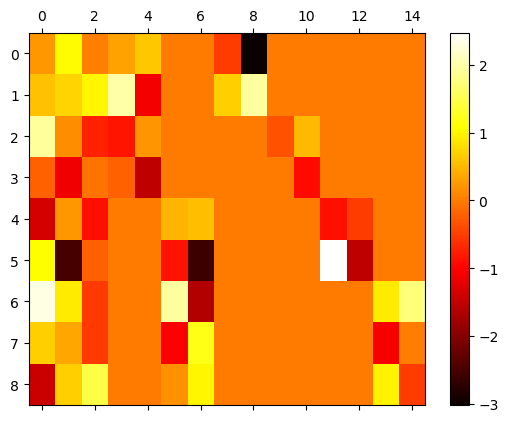

(9, 15)


In [6]:
plt.figure() 
plt.matshow(true_sparse_F, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [7]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [8]:
row_selectors, si_groups, F_hpart = hf.row_col_selections(hpart)

num_levels=4, num_sparsities=4
(4, 3) [0 1 3]


# Variance of log-likelihood of a true model

In [9]:
true_Sigma = hf.perm_hat_Sigma_sp(true_sparse_F, true_D_noise)
tr_lu, tr_piv = scipy.linalg.lu_factor(true_Sigma)

ntest = 10**6
true_test_objs = []

for _ in range(10):
    C_test = hf.generate_data(true_sparse_F, true_D_noise, ntest, true_mlr)
    # permute to put clusters on diagonal
    Z_test = (C_test - C_test.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
    Y_test = Z_test.T
    true_test_objs += [hf.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y_test)]
    # print(f"{true_test_objs[-1]=}")

true_test_objs = np.array(true_test_objs)
print(f"{true_test_objs.mean()=}, {true_test_objs.std()=}")

true_test_objs.mean()=-21.67138718729256, true_test_objs.std()=0.0016901331125507022


In [10]:
true_Sigma = hf.perm_hat_Sigma_sp(true_sparse_F, true_D_noise)
tr_lu, tr_piv = scipy.linalg.lu_factor(true_Sigma)
true_obj_test = hf.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y_test)
exp_true_obj_test = hf.exp_true_loglikelihood_value(true_Sigma)
print(f"{true_obj_test=}, {exp_true_obj_test=}")

true_obj_test=-21.672119284714743, exp_true_obj_test=-21.67192913908178


In [11]:
print(np.linalg.eigvalsh(true_Sigma))

[ 1.07891475  2.73440726  3.07054059  5.16830726  8.28121443 11.21789701
 18.5253312  21.55620258 31.04360212]


# Frobenius vs ML-based loss

In [12]:
obj_frobs = {}
obj_ml = {}
obj_true = {}
for nsamples in [500, 10**3, 10**4, 10**5, 10**6]:
    print(f"{nsamples=}")
    C = hf.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)
    # permute to put clusters on diagonal
    Z = (C - C.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
    unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]
    Y = Z.T

    true_train_obj = hf.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y)
    obj_true[nsamples] = true_train_obj
    print(f"TR: train ll={true_train_obj}, test ll={true_obj_test}")
    
    
    # frobenius fit
    hat_A = mf.MLRMatrix()
    hat_A.hpart = hpart
    losses = hat_A.factor_fit(unpermuted_A, ranks, hat_A.hpart, eps_ff=1e-3, PSD=True, freq=1, \
                                    printing=False, max_iters_ff=50, symm=True)

    F_frob, D_frob = hat_A.B[:, :-1], np.square(hat_A.B[:, -1])
    Sigma_frob = hf.perm_hat_Sigma(F_frob, D_frob, F_hpart, ranks)
    # print(np.linalg.eigvalsh(Sigma_frob))
    lu, piv = scipy.linalg.lu_factor(Sigma_frob)
    obj_frob = hf.loglikelihood_value(Sigma_frob, lu, piv, Y)
    obj_frob_test = hf.loglikelihood_value(Sigma_frob, lu, piv, Y_test)
    print(f"FR: train ll={obj_frob}, test ll={obj_frob_test}, {losses[-1]=}")
    obj_frobs[nsamples] = {"train":obj_frob, "test":obj_frob_test}

    # ML fit
    loglikelihoods, F0, D0 = hf.em_algorithm(n, Y, part_sizes, F_hpart, row_selectors, si_groups, ranks, max_iter=200, 
                 eps=1e-12, printing=False)
    Sigma0 = hf.perm_hat_Sigma(F0, D0, F_hpart, ranks)
    # print(np.linalg.eigvalsh(Sigma0))
    lu, piv = scipy.linalg.lu_factor(Sigma0)
    obj_test = hf.loglikelihood_value(Sigma0, lu, piv, Y_test)
    print(f"ML: train ll={loglikelihoods[-1]}, test ll={obj_test}\n")
    obj_ml[nsamples] = {"train":loglikelihoods[-1], "test":obj_test}

nsamples=500
TR: train ll=-21.571364577569575, test ll=-21.672119284714743


/Users/parshakova.tanya/Documents/projects/MLR_Matrices/mlr_fitting/mlrfit/utils.py:408: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


FR: train ll=-21.558378476212205, test ll=-21.72363156400444, losses[-1]=0.025998114622951787
ML: train ll=-21.53827530160572, test ll=-21.710047095492126

nsamples=1000
TR: train ll=-21.716275757279167, test ll=-21.672119284714743
FR: train ll=-21.71959527048417, test ll=-21.71416333224601, losses[-1]=0.02762308615955892
ML: train ll=-21.700143698142707, test ll=-21.690217368267366

nsamples=10000
TR: train ll=-21.66213972926847, test ll=-21.672119284714743
FR: train ll=-21.689538233023573, test ll=-21.701298114377874, losses[-1]=0.0321891632657393
ML: train ll=-21.6627808140838, test ll=-21.676281534448698

nsamples=100000
TR: train ll=-21.68467215440278, test ll=-21.672119284714743
FR: train ll=-21.71122327930933, test ll=-21.697895423372707, losses[-1]=0.031051444001399562
ML: train ll=-21.700324798053124, test ll=-21.68711166449236

nsamples=1000000
TR: train ll=-21.672168372466505, test ll=-21.672119284714743
FR: train ll=-21.698088833953303, test ll=-21.698233477527058, losses[-

In [13]:
d1 = unpermuted_A * np.sqrt(D_frob)[:, None]
assert np.allclose(d1, np.diag(np.sqrt(D_frob)) @ unpermuted_A)

# Train / test data loglikelihood

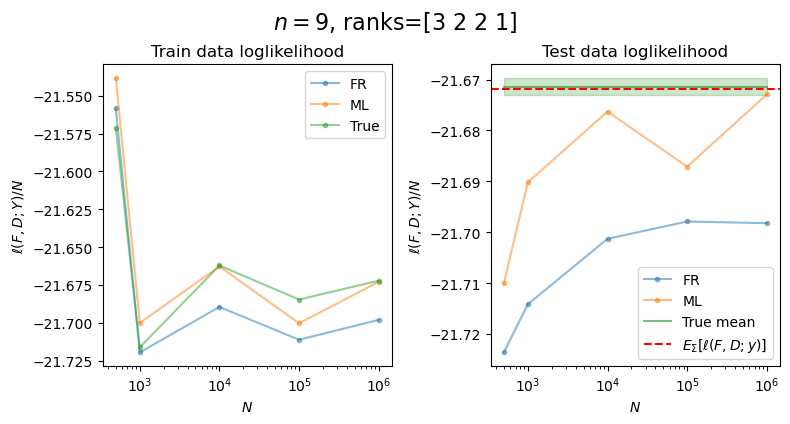

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

x = list(obj_frobs.keys())
# First subplot
ax1.plot(x, [obj_frobs[ns]["train"] for ns in x], label='FR', marker='.', alpha=0.5)
ax1.plot(x, [obj_ml[ns]["train"] for ns in x], label='ML', marker='.', alpha=0.5)
ax1.plot(x, [obj_true[ns] for ns in x], label='True', marker='.', alpha=0.5)
ax1.set_title('Train data loglikelihood')
ax1.set_xscale('log')
ax1.set_ylabel('$\ell(F, D; Y)/N$')
ax1.set_xlabel('$N$')
ax1.legend()

# Second subplot with different example data (modify as needed)
ax2.plot(x, [obj_frobs[ns]["test"] for ns in x], label='FR', marker='.', alpha=0.5)
ax2.plot(x, [obj_ml[ns]["test"] for ns in x], label='ML', marker='.', alpha=0.5)
x_all = np.linspace(x[0], x[-1], num=2)
y_lower = true_test_objs.mean() * np.ones(2) - true_test_objs.std()
y_upper = true_test_objs.mean() * np.ones(2) + true_test_objs.std()
ax2.plot(x_all, true_test_objs.mean()* np.ones(2), label='True mean', c='g', alpha=0.5)
ax2.axhline(y=exp_true_obj_test, color='r', linestyle='--', label=r"$E_\Sigma[\ell(F, D; y)]$")
ax2.fill_between(x_all, y_lower, y_upper, color='g', alpha=0.2)
ax2.set_title('Test data loglikelihood')
ax2.set_ylabel('$\ell(F, D; Y)/N$')
ax2.set_xlabel('$N$')
ax2.set_xscale('log')
ax2.legend()

plt.tight_layout() 
fig.suptitle(f"${n=}$, ranks={str(ranks)}", fontsize=16, y=1.05)
plt.savefig(f"ml_train_test{ranks}.pdf", bbox_inches='tight')
plt.show()

In [15]:
Y_test.shape, F0.shape

((1000000, 9), (9, 7))

In [16]:
tilde_F0 = mf.convert_compressed_to_sparse(F0, F_hpart, ranks[:-1]).toarray()

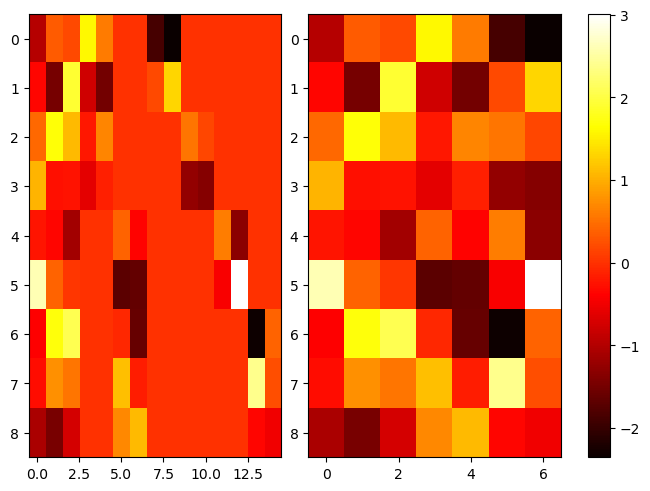

In [17]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)

cax1 = axs[0].imshow(tilde_F0, aspect='auto', cmap='hot')
cax2 = axs[1].imshow(F0, aspect='auto', cmap='hot')

fig.colorbar(cax2, ax=axs, orientation='vertical')